# 0_loader

In [1]:
import torch
from torchvision.datasets import MNIST, FashionMNIST
import medmnist
from medmnist import ChestMNIST, PneumoniaMNIST
from torchvision import transforms
from _utils.load_utils import display_from_batch
from torch.utils.data import Dataset, DataLoader, TensorDataset

# params: batch_size
batch_size = 256

train = FashionMNIST("./_data", train=True, download=True, transform=transforms.ToTensor())
test = FashionMNIST("./_data", train=False, download=True, transform=transforms.ToTensor())
classnames = {
    0:'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle boot',
}
# train = PneumoniaMNIST(root="./_data", split="train", download=True, transform=transforms.ToTensor())
# test = PneumoniaMNIST(root="./_data", split="test", download=True, transform=transforms.ToTensor())
# classnames={0: 'normal', 1: 'pneumonia'}

# train = ChestMNIST(root="./_data", split="train", download=True, transform=transforms.ToTensor())
# test = ChestMNIST(root="./_data", split="test", download=True, transform=transforms.ToTensor())
# classnames={
#     '0': 'atelectasis', 
#     '1': 'cardiomegaly', 
#     '2': 'effusion', 
#     '3': 'infiltration', 
#     '4': 'mass', 
#     '5': 'nodule', 
#     '6': 'pneumonia', 
#     '7': 'pneumothorax', 
#     '8': 'consolidation', 
#     '9': 'edema', 
#     '10': 'emphysema', 
#     '11': 'fibrosis', 
#     '12': 'pleural', 
#     '13': 'hernia'
# }

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

# return train_loader, test_loader

2272it [00:00, 10073423.56it/s]
26721026it [00:00, 1521801380.04it/s]
3424458it [00:00, 1119589826.74it/s]
6082035it [00:00, 708943215.65it/s]
12156055it [00:00, 1818921555.09it/s]
2836386it [00:00, 515453429.17it/s]


BadZipFile: File is not a zip file

In [2]:
print(train)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./_data
    Split: Train
    StandardTransform
Transform: ToTensor()


# _utils

In [3]:
train_iter = iter(train_loader)

tensor([5, 9, 6, 5])


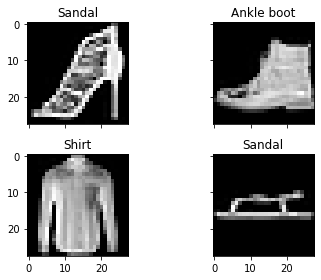

In [4]:
train_batch = next(train_iter)
# params: batch, classname, nrows, ncols
print(train_batch[1][:4])
# print(train_batch[1].squeeze(1))
# print(train_batch[1].squeeze(1).to(torch.long))
# print(train_batch[1].squeeze(1).to(torch.long).dtype)
display_from_batch(train_batch, 2, 2, classnames)

# return none

# 1_model

In [5]:
import torch
from torch import nn, optim

class MyCNN(nn.Module):
    def __init__(self, height, width, out_features):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=0)
        self.act1 = nn.ReLU()
        h = (height - 4)
        w = (width - 4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=0)
        self.act2 = nn.ReLU()
        h = (h - 4)
        w = (w - 4)
        self.pool2 = nn.MaxPool2d(2,2)
        h = h / 2
        w = w / 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=0)
        self.act3 = nn.ReLU()
        h = (h - 4)
        w = (w - 4)
        self.pool3 = nn.MaxPool2d(2,2)
        h = h / 2
        w = w / 2
        # 3x3 이미지가 됨
        self.fc4 = nn.Linear(64 * int(h) * int(w), 100)
        self.act4 = nn.ReLU()
        self.fc5 = nn.Linear(100, out_features)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        
        # 모듈화 필요>>>
        sizes = x.size()
        x = x.view(sizes[0], -1)
        # <<<모듈화 필요
        
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        return x


In [6]:
model = MyCNN(height=28, width=28, out_features=10)
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list
print('MyCNN: ', sum(numel_list), numel_list)

MyCNN:  123222 [400, 16, 12800, 32, 51200, 64, 57600, 100, 1000, 10]


Layer (type:depth-idx)                   Output Shape              Param #
MyCNN                                    --                        --
├─Conv2d: 1-1                            [2, 16, 24, 24]           416
├─ReLU: 1-2                              [2, 16, 24, 24]           --
├─Conv2d: 1-3                            [2, 32, 20, 20]           12,832
├─ReLU: 1-4                              [2, 32, 20, 20]           --
├─MaxPool2d: 1-5                         [2, 32, 10, 10]           --
├─Conv2d: 1-6                            [2, 64, 6, 6]             51,264
├─ReLU: 1-7                              [2, 64, 6, 6]             --
├─MaxPool2d: 1-8                         [2, 64, 3, 3]             --
├─Linear: 1-9                            [2, 100]                  57,700
├─ReLU: 1-10                             [2, 100]                  --
├─Linear: 1-11                           [2, 10]                   1,010
Total params: 123,222
Trainable params: 123,222
Non-trainable params:

# 2_train

In [7]:
import torch
from torch import nn, optim
import collections
import tqdm
all_acc_dict = collections.OrderedDict()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import datetime
current_time = datetime.datetime.today() # 2021-08-15 20:58:43.302125
current_time = current_time.strftime('%Y%m%d%H%M%S') # 20210815205827

In [8]:
def eval_net(model, data_loader, device="cpu"):
    model.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        # y = y.squeeze(1).to(torch.long).to(device)
        with torch.no_grad():
            _, y_pred = model(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

In [9]:
n_epochs = 200

model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

train_losses = []
train_acc = []
val_acc = []
for epoch in range(n_epochs):
    running_loss = 0.0
    model.train()
    n = 0
    n_acc = 0
    # 시간이 많이 걸리므로 tqdm을 사용해서 진행바를 표시
    for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
        xx = xx.to(device)
        yy = yy.to(device)
        # yy = yy.squeeze(1).to(torch.long).to(device)
        h = model(xx)
        loss = loss_fn(h, yy)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n += len(xx)
        _, y_pred = h.max(1)
        n_acc += (yy == y_pred).float().sum().item()
    train_losses.append(running_loss / i)
    # 훈련 데이터의 예측 정확도
    train_acc.append(n_acc / n)

    # 검증 데이터의 예측 정확도
    val_acc.append(eval_net(model, test_loader, device))
    print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)
print('-----------training finished-----------')
print('train_losses: ', train_losses)
print('train_acc: ', train_acc)
print('val_acc: ', val_acc)

100%|██████████| 234/234 [00:04<00:00, 47.64it/s]


0 2.3082125749710802 0.13379740918803418 0.14923878014087677


100%|██████████| 234/234 [00:04<00:00, 47.24it/s]


1 2.252858041182096 0.19471153846153846 0.3350360691547394


100%|██████████| 234/234 [00:04<00:00, 47.06it/s]


2 1.2430854224851715 0.5717815170940171 0.6143830418586731


100%|██████████| 234/234 [00:04<00:00, 47.21it/s]


3 0.8410221074783751 0.680221688034188 0.6953125


100%|██████████| 234/234 [00:04<00:00, 47.14it/s]


4 0.7433677561293344 0.720436030982906 0.737379789352417


100%|██████████| 234/234 [00:04<00:00, 47.65it/s]


5 0.695673637891532 0.7409354967948718 0.7524038553237915


100%|██████████| 234/234 [00:04<00:00, 47.61it/s]


6 0.6669238202050009 0.7501836271367521 0.756911039352417


100%|██████████| 234/234 [00:04<00:00, 47.18it/s]


7 0.639034068507698 0.7614850427350427 0.7683293223381042


100%|██████████| 234/234 [00:04<00:00, 47.37it/s]


8 0.6194167050169261 0.7685797275641025 0.7646234035491943


100%|██████████| 234/234 [00:04<00:00, 47.32it/s]


9 0.5990954746248385 0.7774772970085471 0.7808493971824646


100%|██████████| 234/234 [00:04<00:00, 47.74it/s]


10 0.5841025931384942 0.7846554487179487 0.7843549847602844


100%|██████████| 234/234 [00:04<00:00, 47.35it/s]


11 0.5635592826190424 0.7918836805555556 0.7768429517745972


100%|██████████| 234/234 [00:05<00:00, 45.99it/s]


12 0.5583695183496107 0.7929019764957265 0.7930689454078674


100%|██████████| 234/234 [00:04<00:00, 47.78it/s]


13 0.5401484255115362 0.8006977831196581 0.7985777258872986


100%|██████████| 234/234 [00:04<00:00, 47.12it/s]


14 0.5254608981087484 0.8057725694444444 0.8013822436332703


100%|██████████| 234/234 [00:05<00:00, 46.30it/s]


15 0.516890208096975 0.8107138087606838 0.8027844429016113


100%|██████████| 234/234 [00:05<00:00, 46.33it/s]


16 0.5086876806271434 0.8124332264957265 0.8079928159713745


100%|██████████| 234/234 [00:04<00:00, 47.08it/s]


17 0.49865474222555695 0.8154881143162394 0.8135015964508057


100%|██████████| 234/234 [00:04<00:00, 46.93it/s]


18 0.49142607816299144 0.8177918002136753 0.8172075152397156


100%|██████████| 234/234 [00:04<00:00, 47.16it/s]


19 0.4808423544715914 0.8244691506410257 0.8216146230697632


100%|██████████| 234/234 [00:04<00:00, 47.44it/s]


20 0.47248437284400024 0.8270566239316239 0.8175080418586731


100%|██████████| 234/234 [00:04<00:00, 47.29it/s]


21 0.4657845173526731 0.8293770032051282 0.8114984035491943


100%|██████████| 234/234 [00:04<00:00, 48.36it/s]


22 0.4573972167631076 0.8320145566239316 0.8199118971824646


100%|██████████| 234/234 [00:04<00:00, 47.32it/s]


23 0.4544714270998992 0.8343182425213675 0.8270232677459717


100%|██████████| 234/234 [00:04<00:00, 47.07it/s]


24 0.4430095636537658 0.8388588408119658 0.8114984035491943


100%|██████████| 234/234 [00:04<00:00, 47.60it/s]


25 0.4419199968868059 0.8382244925213675 0.8325320482254028


100%|██████████| 234/234 [00:04<00:00, 46.94it/s]


26 0.43138753932944696 0.8431657318376068 0.833834171295166


100%|██████████| 234/234 [00:04<00:00, 47.32it/s]


27 0.4280324951773549 0.8436331463675214 0.8400440812110901


100%|██████████| 234/234 [00:04<00:00, 47.48it/s]


28 0.4216660689642501 0.8466045673076923 0.8362379670143127


100%|██████████| 234/234 [00:04<00:00, 47.25it/s]


29 0.41713124283393566 0.8483573717948718 0.8378405570983887


100%|██████████| 234/234 [00:04<00:00, 47.15it/s]


30 0.4108292396488108 0.8515625 0.8429487347602844


100%|██████████| 234/234 [00:04<00:00, 49.20it/s]


31 0.40814688418044553 0.8511451655982906 0.8381410241127014


100%|██████████| 234/234 [00:04<00:00, 48.21it/s]


32 0.40221321467677923 0.8544671474358975 0.8508613705635071


100%|██████████| 234/234 [00:05<00:00, 46.25it/s]


33 0.3975040532744494 0.8556523771367521 0.8509615659713745


100%|██████████| 234/234 [00:05<00:00, 46.11it/s]


34 0.3931977587708076 0.8583066239316239 0.8530648946762085


100%|██████████| 234/234 [00:05<00:00, 46.24it/s]


35 0.3910541992330756 0.8580061431623932 0.8412460088729858


100%|██████████| 234/234 [00:05<00:00, 46.02it/s]


36 0.3855864029585548 0.8604934561965812 0.8473557829856873


100%|██████████| 234/234 [00:05<00:00, 46.63it/s]


37 0.37981976242536125 0.8631310096153846 0.8542668223381042


100%|██████████| 234/234 [00:04<00:00, 46.98it/s]


38 0.37866185944479425 0.8634648771367521 0.8539663553237915


100%|██████████| 234/234 [00:04<00:00, 47.11it/s]


39 0.3748461985281097 0.8634314903846154 0.849459171295166


100%|██████████| 234/234 [00:05<00:00, 46.11it/s]


40 0.36834196829488863 0.8669370993589743 0.8596754670143127


100%|██████████| 234/234 [00:04<00:00, 47.08it/s]


41 0.36615328893641036 0.8667868589743589 0.8571714758872986


100%|██████████| 234/234 [00:04<00:00, 47.24it/s]


42 0.36109237334503125 0.8702757745726496 0.8539663553237915


100%|██████████| 234/234 [00:04<00:00, 46.89it/s]


43 0.3591656627317355 0.8698417467948718 0.8564703464508057


100%|██████████| 234/234 [00:04<00:00, 47.73it/s]


44 0.35598166267759296 0.8711104433760684 0.8625801205635071


100%|██████████| 234/234 [00:04<00:00, 47.02it/s]


45 0.3533854953337125 0.8721454326923077 0.8615785241127014


100%|██████████| 234/234 [00:04<00:00, 47.32it/s]


46 0.3521844564333494 0.8731470352564102 0.8601762652397156


100%|██████████| 234/234 [00:04<00:00, 47.47it/s]


47 0.3465236028888195 0.8756176549145299 0.8559695482254028


100%|██████████| 234/234 [00:05<00:00, 45.32it/s]


48 0.3454910761041191 0.8748330662393162 0.8539663553237915


100%|██████████| 234/234 [00:05<00:00, 44.81it/s]


49 0.3421203540758002 0.8759849091880342 0.8630809187889099


100%|██████████| 234/234 [00:04<00:00, 46.88it/s]


50 0.3390004467938591 0.8775540865384616 0.8544671535491943


100%|██████████| 234/234 [00:04<00:00, 46.87it/s]


51 0.3362004529892631 0.8782719017094017 0.8625801205635071


100%|██████████| 234/234 [00:04<00:00, 47.01it/s]


52 0.33433513599148124 0.8784722222222222 0.8686898946762085


100%|██████████| 234/234 [00:04<00:00, 47.37it/s]


53 0.332289915803676 0.8798243856837606 0.8631811141967773


100%|██████████| 234/234 [00:04<00:00, 46.99it/s]


54 0.3305143140288382 0.8804253472222222 0.860276460647583


100%|██████████| 234/234 [00:04<00:00, 46.91it/s]


55 0.32834268850574166 0.8801916399572649 0.8568710088729858


100%|██████████| 234/234 [00:04<00:00, 47.17it/s]


56 0.3237731228442663 0.883346688034188 0.8655849695205688


100%|██████████| 234/234 [00:04<00:00, 48.17it/s]


57 0.3234008056283509 0.8837139423076923 0.8597756624221802


100%|██████████| 234/234 [00:04<00:00, 48.74it/s]


58 0.31815092610954726 0.8855335202991453 0.8643830418586731


100%|██████████| 234/234 [00:04<00:00, 48.09it/s]


59 0.3168608932536047 0.8851495726495726 0.8565705418586731


100%|██████████| 234/234 [00:04<00:00, 47.22it/s]


60 0.31694928943599243 0.8852664262820513 0.8713942170143127


100%|██████████| 234/234 [00:04<00:00, 47.23it/s]


61 0.3145993414610752 0.8856336805555556 0.8657852411270142


100%|██████████| 234/234 [00:05<00:00, 46.69it/s]


62 0.31236069524748644 0.8864349626068376 0.8704928159713745


100%|██████████| 234/234 [00:05<00:00, 46.74it/s]


63 0.30899444887566463 0.8868189102564102 0.8706931471824646


100%|██████████| 234/234 [00:05<00:00, 46.64it/s]


64 0.30744517463471244 0.8874532585470085 0.8751001954078674


100%|██████████| 234/234 [00:04<00:00, 47.20it/s]


65 0.305890337080403 0.8886885683760684 0.8772035241127014


100%|██████████| 234/234 [00:04<00:00, 47.30it/s]


66 0.3028913693494551 0.8904914529914529 0.8756009936332703


100%|██████████| 234/234 [00:04<00:00, 46.91it/s]


67 0.3017762238119805 0.8904413728632479 0.8726963400840759


100%|██████████| 234/234 [00:04<00:00, 47.47it/s]


68 0.30052925339328374 0.8919938568376068 0.8776041865348816


100%|██████████| 234/234 [00:04<00:00, 47.21it/s]


69 0.29896384100289813 0.8910590277777778 0.8727964758872986


100%|██████████| 234/234 [00:04<00:00, 47.43it/s]


70 0.29682247986609334 0.8922943376068376 0.8791065812110901


100%|██████████| 234/234 [00:04<00:00, 47.44it/s]


71 0.29572138241432255 0.8920105502136753 0.8758012652397156


100%|██████████| 234/234 [00:04<00:00, 47.14it/s]


72 0.2948543266293317 0.8926782852564102 0.8778045177459717


100%|██████████| 234/234 [00:04<00:00, 47.17it/s]


73 0.29150326159890627 0.8940638354700855 0.8738982677459717


100%|██████████| 234/234 [00:04<00:00, 47.37it/s]


74 0.29161813637729367 0.8931456997863247 0.8790064454078674


100%|██████████| 234/234 [00:04<00:00, 47.33it/s]


75 0.2887266039080886 0.8949819711538461 0.8781049847602844


100%|██████████| 234/234 [00:04<00:00, 46.93it/s]


76 0.286760876426881 0.8955328525641025 0.8753004670143127


100%|██████████| 234/234 [00:04<00:00, 47.27it/s]


77 0.2871655815404884 0.8954326923076923 0.8790064454078674


100%|██████████| 234/234 [00:04<00:00, 47.34it/s]


78 0.2830408713720387 0.8965511485042735 0.8792067170143127


100%|██████████| 234/234 [00:04<00:00, 47.43it/s]


79 0.2826506294661837 0.8971521100427351 0.8806089758872986


100%|██████████| 234/234 [00:04<00:00, 47.43it/s]


80 0.2805704044042227 0.8973524305555556 0.8725961446762085


100%|██████████| 234/234 [00:04<00:00, 47.35it/s]


81 0.27962649879025797 0.8974525908119658 0.8833132982254028


100%|██████████| 234/234 [00:04<00:00, 47.40it/s]


82 0.27655214103250547 0.8996895032051282 0.8786057829856873


100%|██████████| 234/234 [00:04<00:00, 49.19it/s]


83 0.27607563419403436 0.900123530982906 0.8822115659713745


100%|██████████| 234/234 [00:04<00:00, 47.27it/s]


84 0.27450814312363897 0.9005241720085471 0.879807710647583


100%|██████████| 234/234 [00:04<00:00, 47.17it/s]


85 0.2721810041579054 0.9010416666666666 0.880709171295166


100%|██████████| 234/234 [00:04<00:00, 47.30it/s]


86 0.2703444236337883 0.9004740918803419 0.8833132982254028


100%|██████████| 234/234 [00:04<00:00, 47.15it/s]


87 0.27091381459021263 0.9013588408119658 0.8785056471824646


100%|██████████| 234/234 [00:04<00:00, 47.00it/s]


88 0.2691579645283744 0.9012086004273504 0.8826121687889099


100%|██████████| 234/234 [00:04<00:00, 47.27it/s]


89 0.2676284930992536 0.9028612446581197 0.8839142918586731


100%|██████████| 234/234 [00:04<00:00, 47.14it/s]


90 0.2675682876754728 0.9016927083333334 0.8811097741127014


100%|██████████| 234/234 [00:04<00:00, 47.28it/s]


91 0.26395956890521644 0.9038962339743589 0.8762019276618958


100%|██████████| 234/234 [00:04<00:00, 47.22it/s]


92 0.2640283016943625 0.9036959134615384 0.8858173489570618


100%|██████████| 234/234 [00:04<00:00, 47.57it/s]


93 0.2633257615719742 0.9040965544871795 0.8868189454078674


100%|██████████| 234/234 [00:04<00:00, 47.27it/s]


94 0.2602622040223666 0.9045806623931624 0.8864182829856873


100%|██████████| 234/234 [00:04<00:00, 47.31it/s]


95 0.25916225405593796 0.9058493589743589 0.8857171535491943


100%|██████████| 234/234 [00:04<00:00, 47.34it/s]


96 0.2580102039381158 0.9051983173076923 0.8757011294364929


100%|██████████| 234/234 [00:04<00:00, 46.86it/s]


97 0.2564303653690436 0.906517094017094 0.8799078464508057


100%|██████████| 234/234 [00:04<00:00, 47.13it/s]


98 0.25686749931057123 0.9057825854700855 0.8833132982254028


100%|██████████| 234/234 [00:04<00:00, 47.32it/s]


99 0.25385759431916755 0.9066840277777778 0.880709171295166


100%|██████████| 234/234 [00:05<00:00, 40.30it/s]


100 0.2534114291867473 0.9075520833333334 0.884615421295166


100%|██████████| 234/234 [00:04<00:00, 47.15it/s]


101 0.24974591326560075 0.9080528846153846 0.8883213400840759


100%|██████████| 234/234 [00:05<00:00, 44.96it/s]


102 0.24950325578579063 0.9084201388888888 0.8816105723381042


100%|██████████| 234/234 [00:04<00:00, 47.08it/s]


103 0.2497936712314131 0.9092548076923077 0.8836137652397156


100%|██████████| 234/234 [00:05<00:00, 46.34it/s]


104 0.2484438917539662 0.9082532051282052 0.8853164911270142


100%|██████████| 234/234 [00:05<00:00, 46.28it/s]


105 0.24712409756981762 0.9105235042735043 0.8861178159713745


100%|██████████| 234/234 [00:05<00:00, 46.50it/s]


106 0.24450380511805736 0.9108573717948718 0.8844150900840759


100%|██████████| 234/234 [00:05<00:00, 46.58it/s]


107 0.24389268707308134 0.9108072916666666 0.8815104365348816


100%|██████████| 234/234 [00:04<00:00, 46.99it/s]


108 0.2431341155148371 0.9112913995726496 0.8909254670143127


100%|██████████| 234/234 [00:04<00:00, 46.90it/s]


109 0.242748138986432 0.9102897970085471 0.8872195482254028


100%|██████████| 234/234 [00:04<00:00, 46.91it/s]


110 0.2396014229806196 0.9124933226495726 0.8868189454078674


100%|██████████| 234/234 [00:04<00:00, 46.81it/s]


111 0.240121614971386 0.9116586538461539 0.8865184187889099


100%|██████████| 234/234 [00:04<00:00, 47.35it/s]


112 0.23577625633820956 0.9139790331196581 0.8895232677459717


100%|██████████| 234/234 [00:04<00:00, 47.16it/s]


113 0.23590209677239857 0.9146133814102564 0.8870192170143127


100%|██████████| 234/234 [00:05<00:00, 46.77it/s]


114 0.23465133800527058 0.9141793536324786 0.8893229365348816


100%|██████████| 234/234 [00:05<00:00, 46.39it/s]


115 0.2343479421773182 0.9135450053418803 0.8884214758872986


100%|██████████| 234/234 [00:05<00:00, 46.66it/s]


116 0.2340125543876779 0.9148137019230769 0.8898237347602844


100%|██████████| 234/234 [00:04<00:00, 47.14it/s]


117 0.23214995240704697 0.9149806356837606 0.8907251954078674


100%|██████████| 234/234 [00:04<00:00, 46.95it/s]


118 0.23111582480275067 0.9162660256410257 0.8873197436332703


100%|██████████| 234/234 [00:04<00:00, 46.94it/s]


119 0.2297636227034704 0.9157318376068376 0.8793069124221802


100%|██████████| 234/234 [00:04<00:00, 47.00it/s]


120 0.22765084205778882 0.9175681089743589 0.8845152258872986


100%|██████████| 234/234 [00:04<00:00, 47.91it/s]


121 0.2282502736912265 0.9156817574786325 0.8912259936332703


100%|██████████| 234/234 [00:04<00:00, 47.11it/s]


122 0.22661329901781205 0.9173510950854701 0.8850160241127014


100%|██████████| 234/234 [00:04<00:00, 47.11it/s]


123 0.2237255691586646 0.9178518963675214 0.888521671295166


100%|██████████| 234/234 [00:04<00:00, 47.53it/s]


124 0.22454674298926997 0.9182024572649573 0.8883213400840759


100%|██████████| 234/234 [00:04<00:00, 47.35it/s]


125 0.2235265010288345 0.9188868856837606 0.8913261294364929


100%|██████████| 234/234 [00:05<00:00, 46.75it/s]


126 0.22186126518403 0.9178685897435898 0.8887219429016113


100%|██████████| 234/234 [00:04<00:00, 47.54it/s]


127 0.21913160805794302 0.9203058226495726 0.8903245329856873


100%|██████████| 234/234 [00:05<00:00, 46.77it/s]


128 0.21884256933891721 0.9197215544871795 0.8905248641967773


100%|██████████| 234/234 [00:04<00:00, 46.85it/s]


129 0.2197772422125923 0.9193709935897436 0.8893229365348816


100%|██████████| 234/234 [00:05<00:00, 46.56it/s]


130 0.21764462367659473 0.9202557425213675 0.8914262652397156


100%|██████████| 234/234 [00:05<00:00, 46.61it/s]


131 0.21645508920813836 0.9208066239316239 0.8863181471824646


100%|██████████| 234/234 [00:05<00:00, 46.41it/s]


132 0.21400559159563334 0.9217915331196581 0.8892227411270142


100%|██████████| 234/234 [00:04<00:00, 47.67it/s]


133 0.21325137488575965 0.9222756410256411 0.8871194124221802


100%|██████████| 234/234 [00:05<00:00, 46.19it/s]


134 0.21439234381581582 0.9214910523504274 0.8855168223381042


100%|██████████| 234/234 [00:05<00:00, 46.28it/s]


135 0.21409628041440326 0.9212072649572649 0.8849158883094788


100%|██████████| 234/234 [00:05<00:00, 46.06it/s]


136 0.2108515002185183 0.923293936965812 0.8875200152397156


100%|██████████| 234/234 [00:04<00:00, 47.41it/s]


137 0.20980593520556395 0.9227430555555556 0.8861178159713745


100%|██████████| 234/234 [00:04<00:00, 46.87it/s]


138 0.20827222065480483 0.9228766025641025 0.8870192170143127


100%|██████████| 234/234 [00:04<00:00, 48.02it/s]


139 0.2080294855034914 0.9234107905982906 0.8892227411270142


100%|██████████| 234/234 [00:04<00:00, 46.88it/s]


140 0.20717558779557887 0.9245292467948718 0.892427921295166


100%|██████████| 234/234 [00:04<00:00, 47.03it/s]


141 0.20660566183630488 0.9234942574786325 0.8930288553237915


100%|██████████| 234/234 [00:04<00:00, 46.95it/s]


142 0.20505700762435602 0.9247295673076923 0.8919271230697632


100%|██████████| 234/234 [00:04<00:00, 47.56it/s]


143 0.20336174955311762 0.9262653579059829 0.8816105723381042


100%|██████████| 234/234 [00:04<00:00, 47.41it/s]


144 0.20375829589725053 0.9256477029914529 0.891526460647583


100%|██████████| 234/234 [00:04<00:00, 48.49it/s]


145 0.20157169848040962 0.9260984241452992 0.8829126954078674


100%|██████████| 234/234 [00:04<00:00, 47.98it/s]


146 0.20221416994353733 0.9264322916666666 0.8911257982254028


100%|██████████| 234/234 [00:04<00:00, 47.14it/s]


147 0.19967817064262766 0.9276175213675214 0.8902243971824646


100%|██████████| 234/234 [00:04<00:00, 47.33it/s]


148 0.19762156951708856 0.9270332532051282 0.89453125


100%|██████████| 234/234 [00:04<00:00, 46.90it/s]


149 0.1985883322972085 0.9269497863247863 0.8822115659713745


100%|██████████| 234/234 [00:05<00:00, 45.58it/s]


150 0.19780745936054017 0.9278846153846154 0.8928285241127014


100%|██████████| 234/234 [00:04<00:00, 47.01it/s]


151 0.1979188555811608 0.9266326121794872 0.8942307829856873


100%|██████████| 234/234 [00:04<00:00, 46.88it/s]


152 0.1960931132535566 0.9292868589743589 0.8943309187889099


100%|██████████| 234/234 [00:04<00:00, 46.87it/s]


153 0.1938118595358128 0.9286191239316239 0.8912259936332703


100%|██████████| 234/234 [00:04<00:00, 46.96it/s]


154 0.19331391539440645 0.9290698450854701 0.8908253312110901


100%|██████████| 234/234 [00:04<00:00, 47.01it/s]


155 0.19164636245101307 0.9309228098290598 0.8947315812110901


100%|██████████| 234/234 [00:04<00:00, 46.96it/s]


156 0.19191446842809604 0.9310563568376068 0.8912259936332703


100%|██████████| 234/234 [00:05<00:00, 46.67it/s]


157 0.19149798375470445 0.9294537927350427 0.8941306471824646


100%|██████████| 234/234 [00:04<00:00, 46.84it/s]


158 0.18919136378386503 0.9308894230769231 0.8909254670143127


100%|██████████| 234/234 [00:04<00:00, 47.88it/s]


159 0.18898468106473465 0.9311231303418803 0.8923277258872986


100%|██████████| 234/234 [00:04<00:00, 47.31it/s]


160 0.1871129145502021 0.9312566773504274 0.8921273946762085


100%|██████████| 234/234 [00:04<00:00, 47.59it/s]


161 0.18874254966626353 0.9305722489316239 0.8897235989570618


100%|██████████| 234/234 [00:04<00:00, 47.32it/s]


162 0.18519021877659236 0.9326589209401709 0.8910256624221802


100%|██████████| 234/234 [00:04<00:00, 47.51it/s]


163 0.1870492110628427 0.9317741720085471 0.8934295177459717


100%|██████████| 234/234 [00:04<00:00, 47.32it/s]


164 0.18351752829014487 0.9331597222222222 0.8942307829856873


100%|██████████| 234/234 [00:05<00:00, 46.77it/s]


165 0.18515077837674915 0.9319411057692307 0.8929287195205688


100%|██████████| 234/234 [00:04<00:00, 46.86it/s]


166 0.18349813545210678 0.9326255341880342 0.8899238705635071


100%|██████████| 234/234 [00:04<00:00, 48.49it/s]


167 0.1809100367032919 0.9331263354700855 0.8894230723381042


100%|██████████| 234/234 [00:04<00:00, 47.02it/s]


168 0.17980653696689483 0.9351462339743589 0.8921273946762085


100%|██████████| 234/234 [00:04<00:00, 46.82it/s]


169 0.17912360424647517 0.9346287393162394 0.8866186141967773


100%|██████████| 234/234 [00:05<00:00, 45.93it/s]


170 0.17858286828698006 0.9341112446581197 0.8941306471824646


100%|██████████| 234/234 [00:04<00:00, 47.40it/s]


171 0.17741299871467214 0.9358807425213675 0.8943309187889099


100%|██████████| 234/234 [00:05<00:00, 46.26it/s]


172 0.1765327714543486 0.9350794604700855 0.8884214758872986


100%|██████████| 234/234 [00:05<00:00, 45.87it/s]


173 0.1774552905124656 0.9341112446581197 0.8928285241127014


100%|██████████| 234/234 [00:05<00:00, 45.90it/s]


174 0.1747991762767534 0.9367321047008547 0.8839142918586731


100%|██████████| 234/234 [00:05<00:00, 46.56it/s]


175 0.17334337414206352 0.9368823450854701 0.8800080418586731


100%|██████████| 234/234 [00:04<00:00, 46.97it/s]


176 0.1725760631167326 0.9363648504273504 0.8959335088729858


100%|██████████| 234/234 [00:04<00:00, 47.46it/s]


177 0.17328678343301168 0.9352463942307693 0.8913261294364929


100%|██████████| 234/234 [00:05<00:00, 43.30it/s]


178 0.17328946154900374 0.9355635683760684 0.8921273946762085


100%|██████████| 234/234 [00:05<00:00, 39.92it/s]


179 0.17096037417650223 0.9374165331196581 0.8917267918586731


100%|██████████| 234/234 [00:05<00:00, 42.87it/s]


180 0.168226586167137 0.9392361111111112 0.8948317170143127


100%|██████████| 234/234 [00:04<00:00, 46.81it/s]


181 0.16918632509626544 0.9376836271367521 0.8964343070983887


100%|██████████| 234/234 [00:04<00:00, 47.17it/s]


182 0.16844618924825489 0.9372996794871795 0.8778045177459717


100%|██████████| 234/234 [00:05<00:00, 45.99it/s]


183 0.16759191910724272 0.9379340277777778 0.8919271230697632


100%|██████████| 234/234 [00:04<00:00, 48.33it/s]


184 0.16721057431380637 0.9376669337606838 0.8905248641967773


100%|██████████| 234/234 [00:04<00:00, 46.88it/s]


185 0.1649573116279467 0.9388187767094017 0.8902243971824646


100%|██████████| 234/234 [00:05<00:00, 46.18it/s]


186 0.16356722089609874 0.9400040064102564 0.8934295177459717


100%|██████████| 234/234 [00:05<00:00, 44.60it/s]


187 0.16474880962412755 0.9395866720085471 0.895432710647583


100%|██████████| 234/234 [00:05<00:00, 44.97it/s]


188 0.16189068152924976 0.9404380341880342 0.891526460647583


100%|██████████| 234/234 [00:05<00:00, 46.07it/s]


189 0.1636368639031705 0.939453125 0.887620210647583


100%|██████████| 234/234 [00:05<00:00, 45.79it/s]


190 0.1608997859348555 0.9403211805555556 0.8944311141967773


100%|██████████| 234/234 [00:05<00:00, 46.76it/s]


191 0.16009778091324245 0.9410890758547008 0.8911257982254028


100%|██████████| 234/234 [00:05<00:00, 46.15it/s]


192 0.16016791114991316 0.9408553685897436 0.8904246687889099


100%|██████████| 234/234 [00:04<00:00, 46.93it/s]


193 0.15911653800967426 0.9410389957264957 0.895432710647583


100%|██████████| 234/234 [00:04<00:00, 47.49it/s]


194 0.15837397998750466 0.9420739850427351 0.8959335088729858


100%|██████████| 234/234 [00:05<00:00, 46.08it/s]


195 0.15581644415983315 0.9423076923076923 0.8852163553237915


100%|██████████| 234/234 [00:05<00:00, 45.97it/s]


196 0.15815436063022573 0.9417401175213675 0.8938301205635071


100%|██████████| 234/234 [00:04<00:00, 47.02it/s]


197 0.15520490616432076 0.9427751068376068 0.8920272588729858


100%|██████████| 234/234 [00:04<00:00, 47.86it/s]


198 0.15509574185625166 0.9428919604700855 0.8944311141967773


100%|██████████| 234/234 [00:05<00:00, 46.32it/s]


199 0.15355883938432252 0.943893563034188 0.8911257982254028
-----------training finished-----------
train_losses:  [2.3082125749710802, 2.252858041182096, 1.2430854224851715, 0.8410221074783751, 0.7433677561293344, 0.695673637891532, 0.6669238202050009, 0.639034068507698, 0.6194167050169261, 0.5990954746248385, 0.5841025931384942, 0.5635592826190424, 0.5583695183496107, 0.5401484255115362, 0.5254608981087484, 0.516890208096975, 0.5086876806271434, 0.49865474222555695, 0.49142607816299144, 0.4808423544715914, 0.47248437284400024, 0.4657845173526731, 0.4573972167631076, 0.4544714270998992, 0.4430095636537658, 0.4419199968868059, 0.43138753932944696, 0.4280324951773549, 0.4216660689642501, 0.41713124283393566, 0.4108292396488108, 0.40814688418044553, 0.40221321467677923, 0.3975040532744494, 0.3931977587708076, 0.3910541992330756, 0.3855864029585548, 0.37981976242536125, 0.37866185944479425, 0.3748461985281097, 0.36834196829488863, 0.36615328893641036, 0.36109237334503125, 0.3591656627317

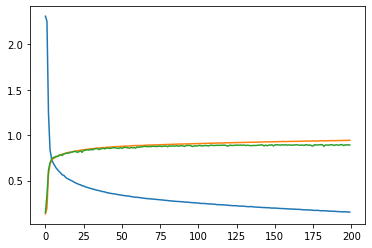

In [10]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(train_acc)
plt.plot(val_acc)